## Airline Tweets Sentiment Analysis

**PURPOSE**: Use NLP to build a model to perform sentiment analysis on tweets for various US Airlines

**AUTHOR** : Maureen Wiebe

**DATA SOURCES**:<br> 
- Kaggle: https://www.kaggle.com/crowdflower/twitter-airline-sentiment
    
**REV DATE**: 6-21-2021


In [1]:
import pandas as pd 
import numpy as np 
import re
import string
import matplotlib.pyplot as plt 
import seaborn as sns 
pd.set_option('max_colwidth', 400)

### Data Import

In [2]:
tweets = pd.read_csv("C:/Users/mwalz2/Documents/Python/Springboard/Airline_Tweets/data/raw/tweets.csv")

### Initial Exploration

In [3]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
tweets.describe(include =["O"])

,airline_sentiment,negativereason,airline,airline_sentiment_gold,name,negativereason_gold,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,14640,9178,14640,40,14640,32,14640,1019,14640,9907,9820
unique,3,10,6,3,7701,13,14427,832,14247,3081,85
top,negative,Customer Service Issue,United,negative,JetBlueNews,Customer Service Issue,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)
freq,9178,2910,3822,32,63,12,6,164,5,157,3744


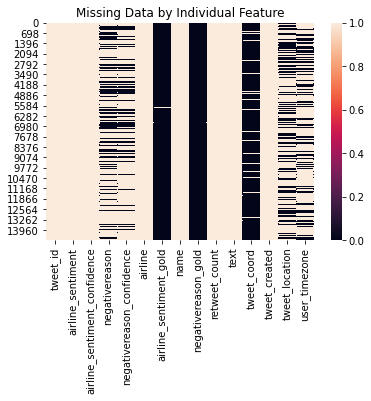

In [6]:
sns.heatmap(~tweets.isna())
plt.title('Missing Data by Individual Feature')
plt.show()

### Tweet Data Cleaning
Tweets come in a very raw format which requires pre-processing to allow the model to meaningfully utilize the data. In this particular case the focus will be: 
+ Count all the hashtags creating a new feature
+ Convert all words to lower case 
+ Removal of mentions (@)
+ Removal of hyperlinks 
+ Removal of numbers 

In [7]:
#retain the original text of the tweet in a new column for future reference 
tweets['org_text'] = tweets['text']

In [8]:
#Create a new feature that contains the number of hashtags
hashtags =[]
for word in tweets.text: 
    hashtags.append(len(re.findall(r"#",word)))
    
tweets['hashtag_count'] = hashtags

In [9]:
#convert all words to lower case 

tweets['text']= tweets.text.str.lower()

In [10]:
#remove @ mentions 

removed =[]

for word in tweets.text: 
    removed.append(re.sub(r"@\S+", "",word))
tweets['text'] = removed 

In [11]:
#remove hyperlinks 
removed =[]

for word in tweets.text: 
    removed.append(re.sub(r"http\S+", "",word))
tweets['text'] = removed 

In [12]:
#remove all digits 

removed =[]

for word in tweets.text: 
    removed.append(re.sub(r"\d+", "",word))
tweets['text'] = removed 

### Tokenization

To allow the model to interpret the text each individual word needs to be separated and will become its own feature. This process is known as tokenization. Another feature will also be created that counts the number of individual words, emojis, and hashtags included in each tweet. 

In [13]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
tokens = []
for word in tweets.text:
    tokens.append(tweet_tokenizer.tokenize(word))
tweets['tokens']=tokens


In [14]:
#add new feature that contains the total number of words in each tweet 

tweets['words']=tweets.tokens.str.len()

### Remove Punctuation & Common Words from Tokens 

Punctuation was retained throughout earlier steps to protect the emojis embedded within tweets. Since each word, punctuation mark, emoji is now stand alone we can easily remove the tokens that are puctuation. 

In [15]:
PUNCUATION_LIST = list(string.punctuation)

def remove_punctuation(word_list):
    """Remove punctuation tokens from a list of tokens"""
    return [w for w in word_list if w not in PUNCUATION_LIST]

In [16]:
tweets['tokens']= tweets['tokens'].apply(remove_punctuation)

In [17]:
from nltk.corpus import stopwords 

stopwords = stopwords.words('english')

def remove_stopwords(word_list):
    """Remove punctuation tokens from a list of tokens"""
    return [w for w in word_list if w not in stopwords]

In [18]:
tweets['tokens']= tweets['tokens'].apply(remove_stopwords)

### Create Corpus and Check Frequency Distribution

The corpus is a way to summarize all of the words that are used in any tweet in the dataset. Through this process it allows us to see the most used words that the model can use to interpret the sentiment of the tweet. 

In [19]:
corpus = tweets['tokens'].sum()

In [20]:
from nltk import FreqDist

frequency_dist = FreqDist(corpus)

In [36]:
frequency_dist.most_common(10)

[('flight', 3898),
 ('get', 1341),
 ('thanks', 1075),
 ('cancelled', 1056),
 ('...', 1019),
 ('service', 959),
 ('help', 846),
 ('time', 775),
 ('customer', 749),
 ('us', 699)]

In [22]:
#The total number of unique tokens in the dataset 
len(frequency_dist)

12427

In [23]:
#count the number of individual hashtags that show up in the frequency dict 

len([(key,value) for key, value in frequency_dist.items() if key.startswith("#")])

1821

### Word Usage 
The vast majority (~85%) of the words are used infrequently (<10) across all the individual tweets. 

In [24]:
len([(key,value) for key, value in frequency_dist.items() if value <10])

10658

### Stemming

To reduce the dimensionality of the dataset words will be stripped down to their root words to reduce the number of unique words overall.  Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.

In [25]:
#Appliyng Stemmer

from nltk.stem import PorterStemmer

ps = PorterStemmer()


def stemming(text):
    text = [ps.stem(word) for word in text]
    return text


tweets['stemmed'] = tweets['tokens'].apply(lambda x: stemming(x))

In [26]:
corpus2 = tweets['stemmed'].sum()
frequency_dist2 = FreqDist(corpus2)

In [27]:
#number of unique tokens is reduced from the original tokenization 
len(frequency_dist2)

9785

In [28]:
#vast majority of tokens still have very low frequency 
len([(key,value) for key, value in frequency_dist2.items() if value <10])

8234

### Lemmatization 
Lemmatization is similar to stemming with the intent to reduce the overall corpus of words but relating words with the same root. Lemmatization relies on grouping together different inflected forms of a word together and retains the context of the words because it uses a dictionary to identify the roots rather than an algorithm like stemming.

In [29]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

def lemmatizing(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    return text


tweets['lemmatizied'] = tweets['tokens'].apply(lambda x: lemmatizing(x))

In [37]:
corpus3 = tweets['lemmatizied'].sum()
frequency_dist3 = FreqDist(corpus3)
frequency_dist3.most_common(5)

[('flight', 4538),
 ('get', 1377),
 ('hour', 1158),
 ('thanks', 1075),
 ('cancelled', 1056)]

In [31]:
#overall reduction was less than stemming 
len(frequency_dist3)

11542

In [32]:
#Appears that more frequently used tokens were not combined with lemmitatization 
len([(key,value) for key, value in frequency_dist3.items() if value <10])

9838

In [33]:
#export to new table to interim dataset 
tweets.to_pickle('C:/Users/mwalz2/Documents/Python/Springboard/Airline_Tweets/data/interim/tweets.pkl')